In [1]:
from prepaid_option import PrepaidOption
from credit import Credit
from holee import HoLee, holee_forwards, holee_spots
import numpy as np
with open('df.txt', 'r') as archivo:
    discount_factors = archivo.read()
    discount_factors = discount_factors.split(',')
    for i in range(len(discount_factors)):
        discount_factors[i] = float(discount_factors[i])
    df = np.array(discount_factors)


In [2]:
r00 = 0.04761
dt = 1/12
N = int(dt**-1) * 5
volat = 0.0016835430755297832
# Leer factores de descuento
with open('df.txt', 'r') as archivo:
    discount_factors = archivo.read()
    discount_factors = discount_factors.split(',')
    for i in range(len(discount_factors)):
        discount_factors[i] = float(discount_factors[i])
    df = np.array(discount_factors)

#ann_r = 7/100
#nom = 100_000_000
#tipo_credito = "bullet"
#credito = Credit(dt, ann_r, N, nom, tipo_credito)

#opt_pre = PrepaidOption(credito, holee_tree)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import comb

def binomial_expectation(A: np.ndarray) -> np.ndarray:
    n = A.shape[0] - 1
    mu = np.zeros(n + 1)
    for j in range(n + 1):
        vals = A[:j+1, j]
        coefs = np.array([comb(j, i) for i in range(j+1)], dtype=float)
        mu[j] = np.sum(coefs * vals) / (2.0**j)
    return mu

def plot_option_lattice(
    A: np.ndarray,
    dt: float,
    title: str = "Árbol de precios de opción de prepago",
    principal: float | None = None,
    show_expectation: bool = True,
    node_ms: float = 1.8,
    edge_lw: float = 0.6,
    y_mode: str = "bps",   # "clp" | "percent" | "bps"
):
    """
    y_mode="bps": grafica en puntos base respecto al principal (requiere principal).
    y_mode="percent": grafica en % del principal (requiere principal).
    y_mode="clp": grafica en CLP (sin normalizar).
    """
    n = A.shape[0] - 1
    T = np.arange(n + 1) * dt

    # Escala según unidad elegida
    if y_mode == "clp":
        Y = A.copy()
        mu = binomial_expectation(A) if show_expectation else None
        y_label = "Costo opción (CLP)"
        y_formatter = None
    elif y_mode == "percent":
        if principal is None:
            raise ValueError("Para percent necesitas 'principal'.")
        Y = A / principal * 100.0
        mu = (binomial_expectation(A) / principal * 100.0) if show_expectation else None
        y_label = "Costo opción (% del capital)"
        y_formatter = FuncFormatter(lambda v, pos: f"{v:.1f}%")
    elif y_mode == "bps":
        if principal is None:
            raise ValueError("Para bps necesitas 'principal'.")
        Y = A / principal * 1e4
        mu = (binomial_expectation(A) / principal * 1e4) if show_expectation else None
        y_label = "Costo opción (bps sobre capital)"
        y_formatter = FuncFormatter(lambda v, pos: f"{v:.0f}")
    else:
        raise ValueError("y_mode debe ser 'clp', 'percent' o 'bps'.")

    fig, ax = plt.subplots(figsize=(9.5, 5.2))

    # Aristas
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(Y[i, j]) and np.isfinite(Y[i, j+1]):
                ax.plot([T[j], T[j+1]], [Y[i, j], Y[i, j+1]], color="red", lw=edge_lw, alpha=0.9)
            if np.isfinite(Y[i, j]) and np.isfinite(Y[i+1, j+1]):
                ax.plot([T[j], T[j+1]], [Y[i, j], Y[i+1, j+1]], color="red", lw=edge_lw, alpha=0.9)

    # Nodos
    for j in range(n + 1):
        y = Y[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=node_ms, color="red", alpha=0.9)

    # Esperanza
    if show_expectation:
        ax.plot(T, mu, color="tab:blue", lw=2.0, label="Costo esperado")
        ax.legend(loc="upper right")

    ax.set_xlabel("Plazo (años)")
    ax.set_ylabel(y_label)
    ax.set_title(title)
    if y_formatter is not None:
        ax.yaxis.set_major_formatter(y_formatter)
    ax.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.savefig("opcfrances56.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.show()


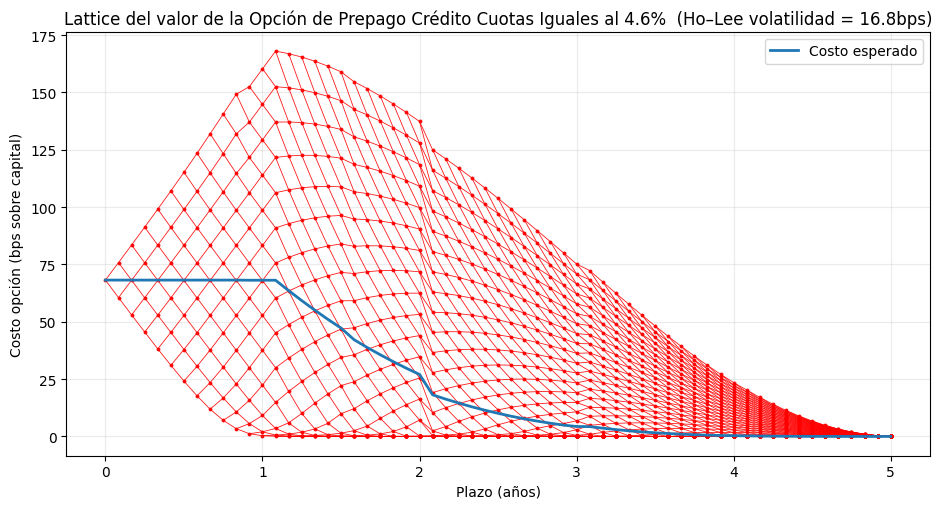

In [10]:
principal = nom


titulo = f"Lattice del valor de la Opción de Prepago Crédito Cuotas Iguales al {round(ann_r*100,2)}%  (Ho–Lee volatilidad = {round(volat*10**4,1)}bps)"
#print(opt_pre.opt_val)
plot_option_lattice(
    opt_french.opt_val,
    dt=dt,
    title=titulo,
    principal=principal,        # para que el eje Y sea %
    show_expectation=True
)

In [7]:
dt = 1/12
N = int(dt**-1) * 5
ann_r = 4.6/100
nom = 100_000_000


r00 = 0.04761
volat = 0.0016835430755297832

holee_tree = HoLee(N, r00, dt, volat, df)
holee_tree.calibrate()


credito_bullet = Credit(dt, ann_r, N, nom, "bullet")
credito_french = Credit(dt, ann_r, N, nom, "french")
credito_german = Credit(dt, ann_r, N, nom, "german")

opt_bullet = PrepaidOption(credito_bullet, holee_tree)
opt_german = PrepaidOption(credito_german, holee_tree)
opt_french = PrepaidOption(credito_french, holee_tree)

print(f"bullet: {round(opt_bullet.opt_val[0,0]/nom * 10**4,2)}bps")
print(f"french: {round(opt_french.opt_val[0,0]/nom * 10**4,2)}bps")
print(f"german: {round(opt_german.opt_val[0,0]/nom * 10**4,2)}bps")



bullet: 134.72bps
french: 68.18bps
german: 64.89bps


In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
def pascal_factors_funct(m: int) -> np.array:
    pascal_factors = np.zeros([m,m])
    for j in range(m):
        for i in range(m):
            if i == 0 or i==j:
                pascal_factors[i][j] = 1
            else:
                pascal_factors[i][j] = pascal_factors[i][j-1] + pascal_factors[i-1][j-1]
    return pascal_factors

def esperanza(m: int, r: np.array, pascal_factors: np.array) -> np.array:
    expected_value = np.zeros(m+1)
    for t in range(m+1):
        expected_value[t] = 2 ** (-t)*np.dot(r[:,t], pascal_factors[:,t])
    return expected_value

from matplotlib.ticker import PercentFormatter

def plot_ho_lee_lattice(
    r: np.ndarray,
    dt: float,
    sigma: float,
    title: str = "Lattice de Ho–Lee",
    mostrar_esperanza: bool = False
):
    """
    r : matriz triangular (n+1 x n+1) con r[i,j] definido para i<=j (NaN fuera)
        r en DECIMAL (p.ej. 0.0184 = 1.84%)
    dt : tamaño del paso en años (ej: 1/12 si mensuales, 0.25 si trimestrales)
    sigma : volatilidad anual (decimal)
    mostrar_esperanza : si True, traza E[r_t] usando pascal_factors_funct y esperanza
                        (deben existir en el namespace)
    """
    n = r.shape[0] - 1
    T = np.arange(n + 1) * dt  # eje en años

    fig, ax = plt.subplots(figsize=(10, 5))

    # --- aristas del lattice ---
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(r[i, j]) and np.isfinite(r[i, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i, j+1]], color="red", lw=0.8)
            if np.isfinite(r[i, j]) and np.isfinite(r[i+1, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i+1, j+1]], color="red", lw=0.8)

    # --- nodos ---
    for j in range(n + 1):
        y = r[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=2, color="black")

    # --- esperanza por tenor (opcional) ---
    if mostrar_esperanza:
        m = n  # nº total de pasos (meses si dt=1/12)
        # llamamos a TUS funciones (se asume que están definidas en tu entorno)
        pascal_factors = pascal_factors_funct(m+1)
        mu = esperanza(m, r, pascal_factors)  # vector de largo m+1
        ax.plot(T, mu, lw=2.2, color="blue", label="Valor esperado en plazo t")
        ax.legend(loc="upper left")
    # formato ejes
    ax.set_xlim(T[0], T[-1])
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # r en %
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Plazo (años)")
    ax.set_ylabel("Tasa")

    ax.set_title(f"{title} calibrado (NR) a mercado 15 septiembre de 2025 con volatilidad σ = {round(sigma*100*100,2)}bps")
    plt.savefig("holee_ewma.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.tight_layout()
    plt.show()

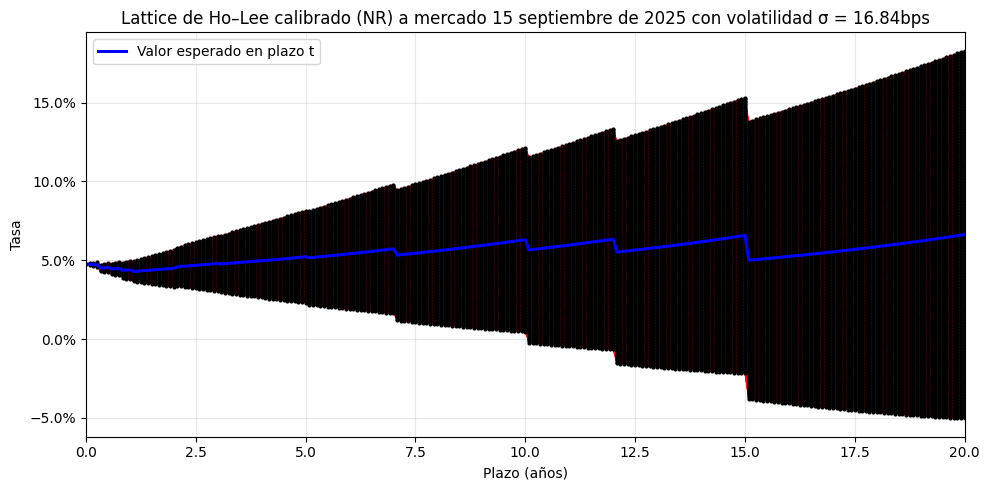

In [13]:
plot_ho_lee_lattice(holee_tree.r, dt=dt, sigma = volat, mostrar_esperanza=True)

In [14]:
68.17*10**-4*100

0.6817

In [15]:
120.99*10**-4*100

1.2099

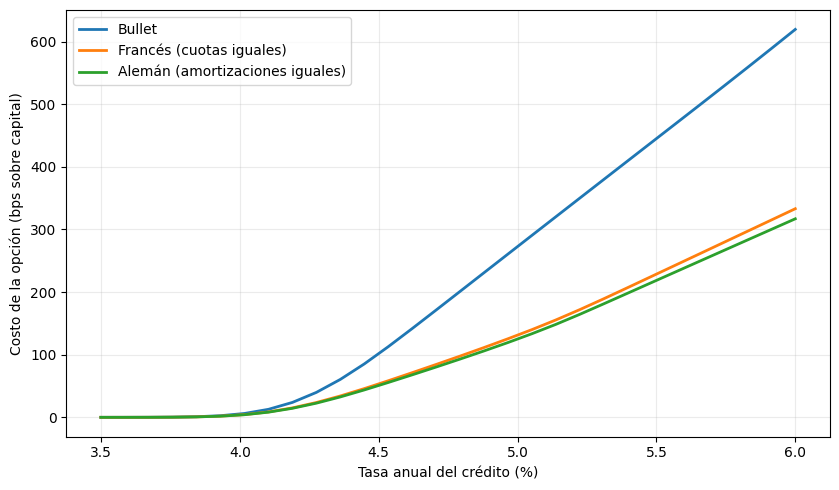

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros base (los mismos que usas) ---
dt   = 1/12
N    = int(1/dt) * 5              # 5 años mensuales
nom  = 100_000_000
r00  = 0.04761
vol  = 0.0016835430755297832

# Árbol de tasas Ho–Lee (calibrado una sola vez)
holee = HoLee(N, r00, dt, vol, df)   # df: lo que ya uses para calibrar
holee.calibrate()

# --- Función: bps de la opción para una tasa y un tipo de crédito ---
def option_bps_for_rate(ann_rate: float, kind: str) -> float:
    """
    kind ∈ {"bullet", "french", "german"} según tu clase Credit.
    Devuelve costo en bps medido como (valor opción / nominal)*1e4.
    """
    cred = Credit(dt, ann_rate, N, nom, kind)
    opt  = PrepaidOption(cred, holee)
    val  = float(opt.opt_val[0, 0])      # valor en CLP
    bps  = 1e4 * val / nom               # bps sobre capital
    return bps

# --- Barrido de tasas ---
rates = np.linspace(0.035, 0.06, 30)   # 3% → 6% anual
bps_bullet = np.array([option_bps_for_rate(r, "bullet")  for r in rates])
bps_french = np.array([option_bps_for_rate(r, "french")  for r in rates])
bps_german = np.array([option_bps_for_rate(r, "german")  for r in rates])

# --- Plot ---
fig, ax = plt.subplots(figsize=(8.5, 5))
ax.plot(rates*100, bps_bullet,  label="Bullet",                        lw=2)
ax.plot(rates*100, bps_french,  label="Francés (cuotas iguales)",      lw=2)
ax.plot(rates*100, bps_german,  label="Alemán (amortizaciones iguales)", lw=2)

ax.set_xlabel("Tasa anual del crédito (%)")
ax.set_ylabel("Costo de la opción (bps sobre capital)")
ax.grid(True, alpha=0.25)
ax.legend()
plt.tight_layout()
plt.show()

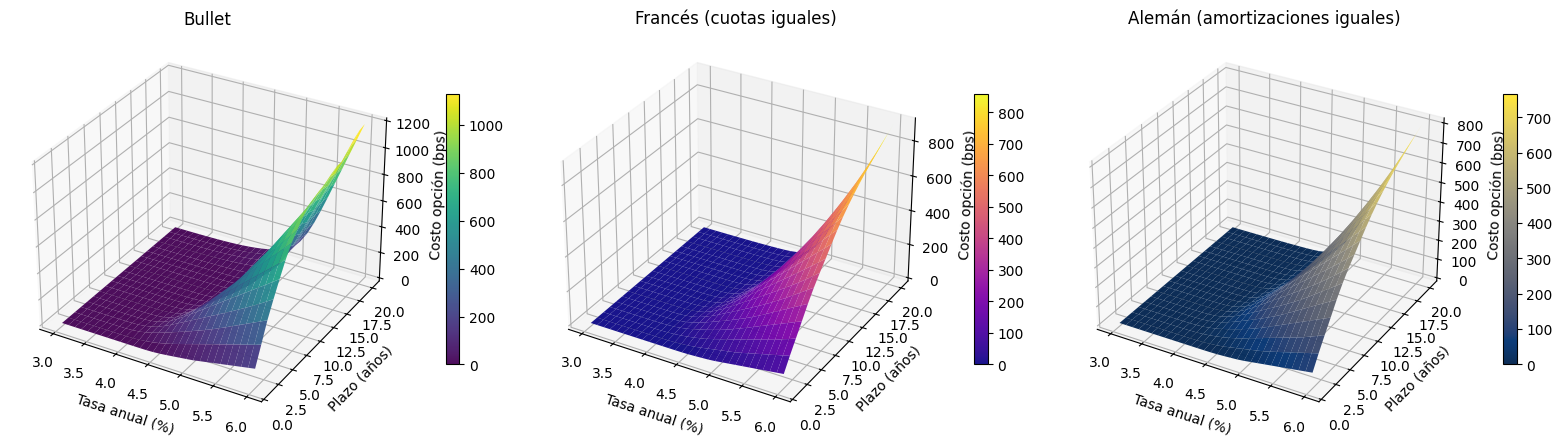

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =========================
# Parámetros ajustables
# =========================
dt         = 1/12
nom        = 100_000_000
r00        = 0.04761
vol        = 0.0016835430755297832
df_full    = df  # usa tu vector/estructura de factores de descuento con horizonte suficiente

# Rango de tasas anuales (% en X)
rate_min, rate_max = 3.0, 6.0   # de 3% a 6%
n_rates             = 30
rates = np.linspace(rate_min/100, rate_max/100, n_rates)  # en decimal

# Rango de plazos en años (Y)
tenor_min, tenor_max, tenor_step = 1.0, 20.0, 1.0         # de 1 a 10 años, paso de 1
tenors_years = np.arange(tenor_min, tenor_max + 1e-9, tenor_step)

# ==========================================
# Helpers: árbol por plazo y bps por tasa
# ==========================================
def build_holee_for_tenor(T_years: float):
    """Crea y calibra un Ho-Lee para un horizonte de T_years."""
    N = int(round(T_years / dt))  # pasos
    tree = HoLee(N, r00, dt, vol, df_full)
    tree.calibrate()
    return tree, N

def option_bps_for_rate_tree(ann_rate: float, kind: str, holee, N_steps: int) -> float:
    """Costo en bps (A00/nom*1e4) para una tasa y un tipo de crédito dado un árbol ya calibrado."""
    cred = Credit(dt, ann_rate, N_steps, nom, kind)
    opt  = PrepaidOption(cred, holee)
    val  = float(opt.opt_val[0, 0])          # CLP
    return 1e4 * val / nom                   # bps sobre capital

# ==================================================
# Construcción de superficies (una por tipo crédito)
# ==================================================
def build_surface(kind: str):
    Z = np.zeros((len(tenors_years), len(rates)))
    for t_idx, T_yrs in enumerate(tenors_years):
        holee, N_steps = build_holee_for_tenor(T_yrs)   # árbol para ese plazo
        # barrido de tasas con el mismo árbol (eficiente)
        for r_idx, r_ann in enumerate(rates):
            Z[t_idx, r_idx] = option_bps_for_rate_tree(r_ann, kind, holee, N_steps)
    return Z

Z_bullet = build_surface("bullet")
Z_french = build_surface("french")
Z_german = build_surface("german")

# ===================
# Gráfica 3D (3 paneles)
# ===================
X, Y = np.meshgrid(rates*100, tenors_years, indexing='xy')  # X: % anual, Y: años

fig = plt.figure(figsize=(16, 4.8))

ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(X, Y, Z_bullet, cmap="viridis", linewidth=0, antialiased=True, alpha=0.95)
ax1.set_title("Crédito Bullet")
ax1.set_xlabel("Tasa anual (%)")
ax1.set_ylabel("Plazo (años)")
ax1.set_zlabel("Costo opción (bps)")
fig.colorbar(surf1, ax=ax1, shrink=0.6, pad=0.08)

ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(X, Y, Z_french, cmap="plasma", linewidth=0, antialiased=True, alpha=0.95)
ax2.set_title("Crédito Francés (cuotas iguales)")
ax2.set_xlabel("Tasa anual (%)")
ax2.set_ylabel("Plazo (años)")
ax2.set_zlabel("Costo opción (bps)")
fig.colorbar(surf2, ax=ax2, shrink=0.6, pad=0.08)

ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(X, Y, Z_german, cmap="cividis", linewidth=0, antialiased=True, alpha=0.95)
ax3.set_title("Crédito Alemán (amortizaciones iguales)")
ax3.set_xlabel("Tasa anual (%)")
ax3.set_ylabel("Plazo (años)")
ax3.set_zlabel("Costo opción (bps)")
fig.colorbar(surf3, ax=ax3, shrink=0.6, pad=0.08)

plt.tight_layout()
plt.savefig("surfaces.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()
